# Acquire and process text data from news websites using Python

## Background


Goal:

Currently, I have used data from geographical domain, like geospatial data. But I have never used text data before, so I am not familiar with how to acquire and handle text data, such as news articles and social media posts.

At the end of this course, I would like to be able to acquire text data from news websites using web scrapers and analyze these data in Python.

Therefore, I will produce an executable Python Jupyter notebook which shows how a web scraper acquires text data from news websites and analyze the text data using word cloud.

**Note**: Our project is about investigating causes and impacts of air pollution in Poland. News / social media analysis (text analysis) was part of our project plan, but we didn't managed to do it due to limited time. This part is also one of my individual goals. So I decided to do this part after the final project presentation by myself. This notebook demonstrates the process of how I accomplished this part.

## Methodology and data source used


**Methodology**:
1. Web scraper:

  It is a technique to fetch data from websites.

  Scraping can be done in a platform like Apify or a browser extension. I want to fetch the text data from a news website in Poland. It can't be done in Apify for free and it not designed for my requirement. So I decided to learn how to make a web scraper in Python on geeksforgeeks. The web scraper is based on the HTML structure of an website, and it can also be used in other news websites as long as change the url template.

2. Word cloud:

  The more a specific word appears in a source of textual data, the bigger and bolder it appears in the word cloud.

  I use word cloud to demonstrate the text data I fetched from the Polish news website to find out what is the most popular word about air pollution in Poland from 2019 to 2023.

Reference:

https://www.geeksforgeeks.org/introduction-to-web-scraping/

https://boostlabs.com/what-are-word-clouds-value-simple-visualizations/


**Data source**:

**[wyborcza.pl](https://wyborcza.pl/)**: a popular news website in Poland

  It ranks 2nd in [Top 30 Poland News Websites](https://journalists.feedspot.com/poland_news_websites/). It also has the most posts per day, which is 30 posts/day. So I can get the most news post in a specific time span. This is the reason why I choose this website as the data source.

  I use the title of news from the search result of 'zanieczyszczenie powietrza' (air pollution in English) in [wyborcza.pl](https://wyborcza.pl/). I also set the order of results as accuracy. The data range is from 1st of January to 31st of December of each year. The page number to fetch is set as 10 and it would include the 200 most related results each year.


## Details about the implementation


### Import the libraries

I used Google Colaboratory to write and run the scripts. Most libraries can be automatically installed without running 'pip install'. But there are some libraries that need to be installed manually, like many_stop_words. So, I will provide the 'pip install' lines for all the libraries I used.

In [ ]:
# install the libraries
%pip install requests
%pip install numpy
%pip install pandas
%pip install bs4
%pip install matplotlib
%pip install wordcloud
%pip install many_stop_words
%pip install translate

import requests
import numpy as np
import pandas as pd
import bs4
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from many_stop_words import get_stop_words
from translate import Translator
import string

### Create and run a web scraper for news websites

**Process and challenges:**

I learned how to build a web scraper from [how-to-build-web-scraping-bot-in-python](https://www.geeksforgeeks.org/how-to-build-web-scraping-bot-in-python/?ref=gcse). But this example can't solve my problem. It is used to scrape the newest news in Google News each 10 mins. But I need historical news in a time range.

Fortunately, when I was browsering the news website, I find that it has search conditions in the url. After checked my idea, I managed to change the time range of search by change a few letters in the url. So I changed all the search conditions in the url to variables. Then I got this:

`"https://wyborcza.pl/0,91794.html?searchType=ARTICLE&query=" + keyword + "&dateTo=" + enddate + "&orderBy=" + orderby + "&dateFrom=" + startdate + "&offset=" + offset`

With this url, I had access to the search result page that has a specific keyword, date range, order and page number.

After this, I tried to fetch all the titles in the search result pages using newspaper3k, this idea is from [Newspaper: Article scraping & curation (Python)](https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/?ref=header_search). Ideally, if I have the links to news articles, I can easily get the titles from the websites using newspaper3k. So, I used this line to get all the links in each result page:

`newslinks = soup.find_all("a")`

But after apply this method, i found that it didn't only return the links to the news I want, also returned some other links like ads and recommeneded readings.

After read [Difference between find and find_all in BeautifulSoup](https://www.geeksforgeeks.org/difference-between-find-and-find_all-in-beautifulsoup-python/?ref=header_search),
I got to know that websites are ususally made by HTML and I learned some basic knowledge of how a website is structured. Then I realized that I can directly get the title of each news article. This is the line for fetching titles after changing the variable in find_all():

 `newstitles = soup.find_all("a", {'class':'result__header-ref'})`

Then I successfully got the top 200 news most related to air pollution in Poland each year from 2019 to 2023 in [wyborcza.pl](https://wyborcza.pl/).

I spent most of my time trying to make a web scraper for a news website, but it was worth it. I learned how to create a functional and reliable web scraper to fetch text data.

In [ ]:
# Set the number of pages, keyword, orderby
page_number = 10
keyword= "zanieczyszczenie powietrza"
orderby= "accuracy"

# Create an empty dataframe
titleperpage_df = pd.DataFrame()

# Iterate each page
for page in range(page_number):
  # Set the number of results to fetch
  offset = str((page+1)*20)

  # Create an empty dataframe
  titleperyear_df = pd.DataFrame()

  # Iterate the year from 2019 to 2023
  for year in range(2019,2024):
    years = str(year)
    column_name = f'column_{year}'

    # Set the start date and end date
    startdate = years + '-01-01'
    enddate = years + '-12-31'

    # Combine all the conditions of a search in a url
    url = "https://wyborcza.pl/0,91794.html?searchType=ARTICLE&query=" + keyword + "&dateTo=" + enddate + "&orderBy=" + orderby + "&dateFrom=" + startdate + "&offset=" + offset

    # Request titles from the news website
    request_result=requests.get( url )

    # Parse the HTML content using BeautifulSoup
    soup = bs4.BeautifulSoup(request_result.text, "html.parser")    # From https://www.geeksforgeeks.org/how-to-build-web-scraping-bot-in-python/?ref=gcse & https://www.geeksforgeeks.org/scrape-google-search-results-using-python-beautifulsoup/?ref=header_search

    # Extract news titles from the parsed HTML
    newstitles = soup.find_all("a", {'class':'result__header-ref'})       # From https://www.geeksforgeeks.org/difference-between-find-and-find_all-in-beautifulsoup-python/?ref=header_search

    # Create a list to store extracted titles
    title_list = [ ]

    # Iterate through the extracted titles and append them to the list
    for title in newstitles:
      title_list.append(title.get_text())

    # Add the list of titles to the dataframe with the corresponding column name
    titleperyear_df[column_name] = title_list

  # Concatenate the dataframe for each year to the main dataframe
  titleperpage_df = pd.concat([titleperpage_df, titleperyear_df], ignore_index=True)

### Inspect the titles

In [ ]:
titleperpage_df

,column_2019,column_2020,column_2021,column_2022,column_2023
0,Czy trzeba dowozić dzieci pod drzwi szkoły? [L...,Smog dusi Kraków i Małopolskę. Normy zanieczys...,Smog w Poznaniu. W Nowy Rok zakaz palenia w ko...,"Smog na Podhalu. Mobilne płuca, które stanęły ...","PiS zablokowało wiatraki, a teraz kręci sztucz..."
1,Smog sprzyja chorobom psychicznym i neurologic...,Smog i koronawirus to śmiertelny koktajl,Z powodu smogu w Polsce umiera tyle samo osób ...,Nowa stacja pomiaru jakości powietrza w Zielon...,"New Jersey dołącza do stanów, które zakazują s..."
2,Smog w Bydgoszczy. Już przekroczyliśmy limit d...,"Boimy się koronawirusa, tymczasem zabija nas c...",Tablice Systemu Dynamicznej Informacji Pasażer...,"Jan Duda, ojciec prezydenta RP: Smog jest bodź...",Mateuszowi Morawieckiemu wygrać ze smogiem się...
3,Co smog robi z mózgiem dziecka?,We wtorek w Poznaniu znowu przekroczone normy ...,Mróz i bardzo zła jakość powietrza w Bydgoszcz...,Fundacja Ekologiczna Arka zaprasza do zbierani...,To pierwsza taka diagnoza w Polsce. Lekarka or...
4,Smog w Krakowie. Obowiązuje I stopień zagrożen...,Katowice znalazły się na okładce komiksu wydan...,"Krakowska firma Airly z 3,3 mln dolarów od zał...",Wielki pożar składowiska odpadów w Lęborku,180 na 211 badanych miejscowości oddycha smogi...
...,...,...,...,...,...
195,Nowa broń w walce ze smogiem - drony z czujnik...,Nie tylko mgła. To rekordowy smog w całej Pols...,Polski Alarm Smogowy wskazuje najbardziej zani...,Deklaracja o emisyjności budynków potrzebna pr...,Miny i niewybuchy. Jak długo potrwa rozminowyw...
196,Żakowska: Prezydent Soszyński nie chce walczyć...,"Szybsze ekointerwencje, bez dotacji na kotły w...","Prezes fundacji FOTA4Climate: ""Energia jądrowa...",Smog. Część województw chce złagodzenia uchwał...,"Szambo niedaleko ogrodu botanicznego, szkoła p..."
197,"Wiedzą, jak walczyć ze smogiem. Wymyślili LMA,...","Potrzebna dobra energia, czyli jak pokonać smog",Gdzie spaliny z aut trują mieszkańców Warszawy...,Odra umiera na naszych oczach. Ale trucie pols...,"Teraz każdy może sprawdzić, jakim powietrzem o..."
198,Badania płuc i serca wypadły zastraszająco,Ambitne plany Hochland Polska w Kaźmierzu,Politechnika Rzeszowska chce uruchomić własną ...,Skawina przeciwna łagodzeniu i opóźnianiu uchw...,Opole miastem wojewódzkim z najlepszą jakością...


### Apply word cloud and visualization

**Process and challenges:**

I tried to translate the titles to English but there are two main problems. First, most translate library needs API key which is not free. Even they provide free available times, it was still not enough for my whole dataset if I want to make word cloud in English. For example. [translate 3.6.1](https://pypi.org/project/translate/). Second, the translate results were not perfect.

And the [many_stop_words](https://pypi.org/project/many-stop-words/) happened to have Polish stop words. Stop words are used for removing meaningless words so that I can making word cloud with meaningful words.

So, due to the above reasons, I decided to skip the translation step and make word clouds. Then I try to make a frequency bar chart for the top 10 words and translate them into English, so that I can interpret the results. But I found that there some key words that are same. It is because there is whitespace at the beginning of the word. As follows:

`{' smog': 43, 'air': 10, 'norms': 10, 'exceeded': 9, 'kraków': 8, 'coronavirus': 8, 'smog': 7, 'city': 8}`

So, I use a few lines to solve this problem:

```
  # Merge frequencies for identical keys
  merged_translated_frequencies = {}
  for word, frequency in translated_frequencies.items():
      # Remove whitespaces
      word = word.strip()

      if word in merged_translated_frequencies:
          merged_translated_frequencies[word] += frequency
      else:
          merged_translated_frequencies[word] = frequency
```

After plot the bar chart, I found that there were some phrases in the chart. But this problem is inevitable if translate Polish into English. Because some word in Polish can be translated into 2 or more words.


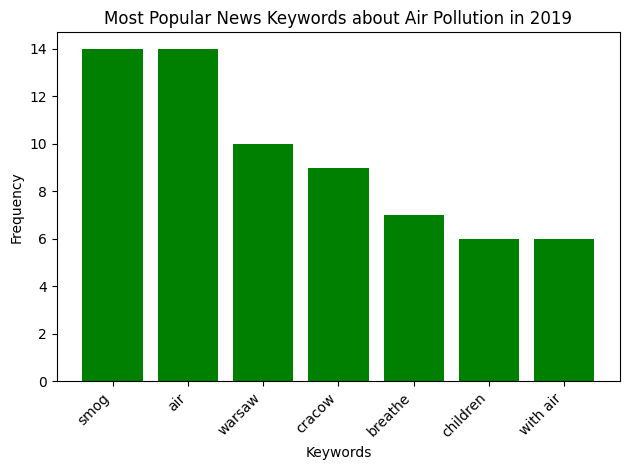

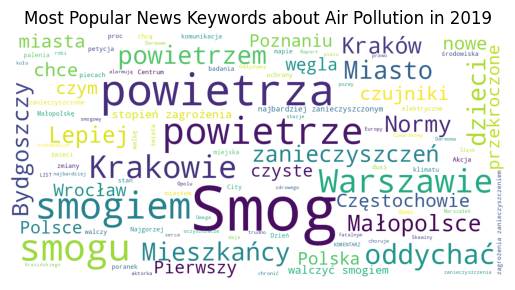

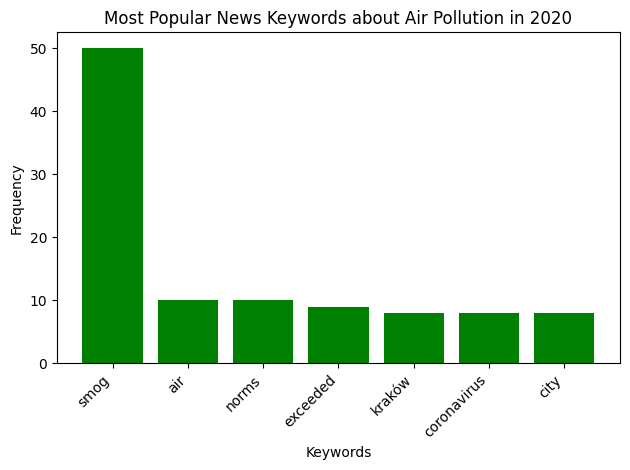

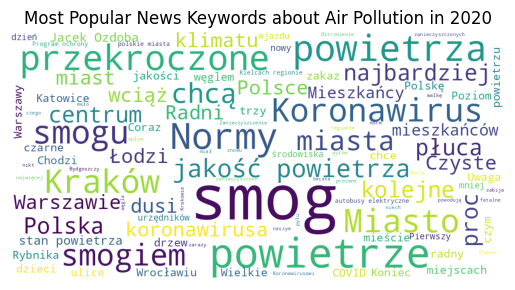

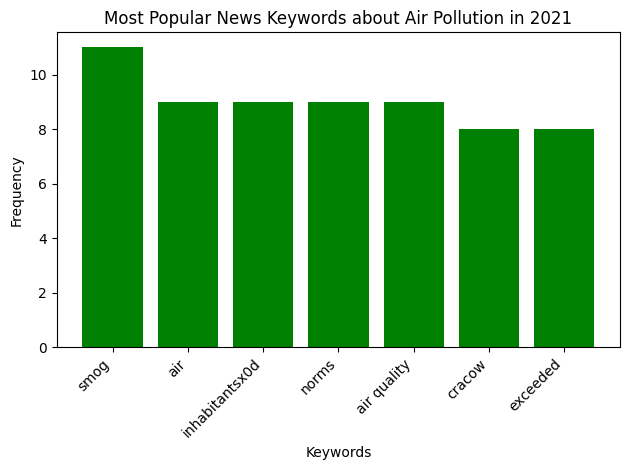

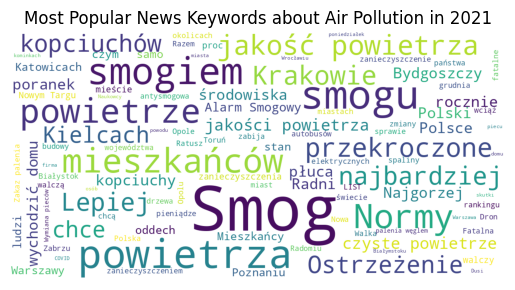

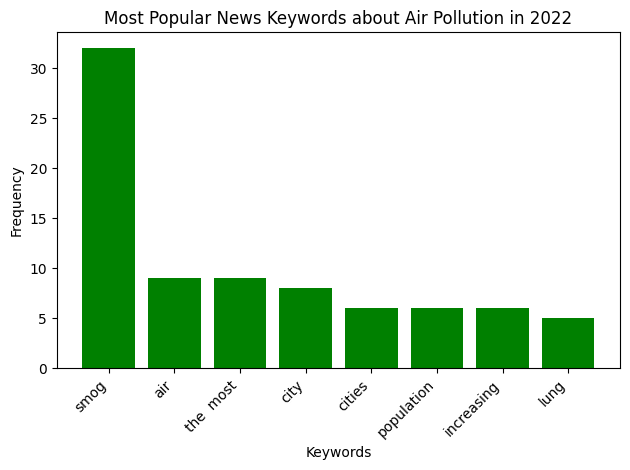

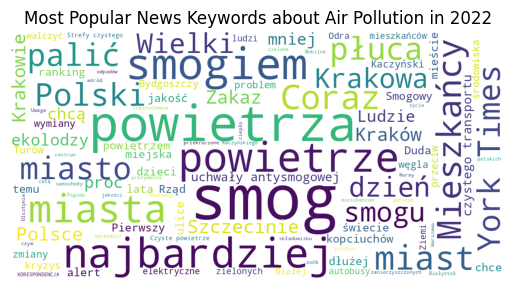

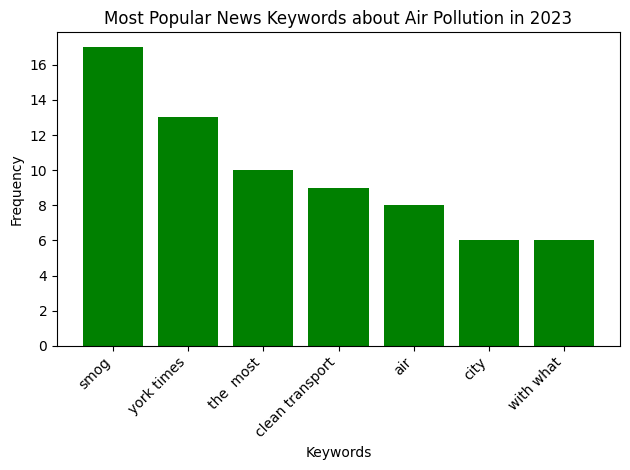

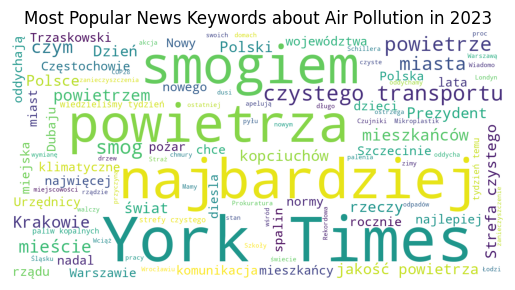

In [ ]:
# Function to remove punctuation from a string
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))      # From https://www.geeksforgeeks.org/python-remove-punctuation-from-string/?ref=gcse

# Define a function to generate and display a word cloud
def wordcloud_generate(column, title=None):
  """
  Generate a word cloud from a specific year and display it using matplotlib.

  Parameters:
  - column (str): The name of the column in the DataFrame containing the text data.
  - title (str): The title for the word cloud.

  Returns:
  word cloud image, word_frequency and bar chart
  """
  # Get stop words for the Polish language
  stop_words = get_stop_words('pl')

  # Concatenate all sentences into a single text
  all_text = ' '.join(titleperpage_df[column])

  # Create a WordCloud object
  wordcloud = WordCloud(
                      background_color='white',
                      min_word_length=4,
                      max_font_size=50,
                      stopwords=stop_words,
                      scale=3,
                      max_words=100,
                      random_state=40
  ).generate(all_text)       # From https://www.geeksforgeeks.org/generating-word-cloud-python/?ref=header_search

  # Get the frequency list
  word_frequency = wordcloud.process_text(all_text)     # From https://www.topcoder.com/thrive/articles/word-cloud-in-python

  # Get the top 10 words by frequency
  top_10_words = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)[:10]

  # Translate words using DeepL
  translator = Translator(from_lang='pl', to_lang='en')

  translated_frequencies = {}

  # Iterate through the top 10 words
  for word, frequency in top_10_words:
      try:
          # Translate the word using the translator
          translated_word = translator.translate(word)

          # Convert the translated word to lowercase
          translated_lowercase_word  = translated_word.lower()    # From https://www.w3schools.com/python/ref_string_lower.asp

          # Remove punctuation from translated words
          new_word = remove_punctuation(translated_lowercase_word)

          # Store the translated lowercase word and its frequency
          translated_frequencies[new_word] = frequency
      except Exception as e:
          print(f"Translation failed for word: {word}. Error: {e}")       # From https://stackoverflow.com/questions/77520770/getting-error-while-translating-the-language-to-english

  # Merge frequencies for identical keys
  merged_translated_frequencies = {}
  for word, frequency in translated_frequencies.items():
      # Remove whitespaces
      word = word.strip()       # From https://www.geeksforgeeks.org/python-string-strip/?ref=header_search

      if word in merged_translated_frequencies:
          merged_translated_frequencies[word] += frequency
      else:
          merged_translated_frequencies[word] = frequency

  # Bar chart in decreasing order
  sorted_translated_frequencies = sorted(merged_translated_frequencies.items(), key=lambda x: x[1], reverse=True)

  plt.bar([word for word, _ in sorted_translated_frequencies], [frequency for _, frequency in sorted_translated_frequencies], color='green') # From https://www.geeksforgeeks.org/bar-plot-in-matplotlib/?ref=gcse

  plt.xlabel('Keywords')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

  print(" ")

  # Display the word cloud using matplotlib
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.title(title,fontsize=12)
  plt.show()

# Generate and display word clouds for different years
wordcloud_generate('column_2019','Most Popular News Keywords about Air Pollution in 2019')
print(" ")

wordcloud_generate('column_2020','Most Popular News Keywords about Air Pollution in 2020')
print(" ")

wordcloud_generate('column_2021','Most Popular News Keywords about Air Pollution in 2021')
print(" ")

wordcloud_generate('column_2022','Most Popular News Keywords about Air Pollution in 2022')
print(" ")

wordcloud_generate('column_2023','Most Popular News Keywords about Air Pollution in 2023')

## Results
As is shown in the previous output, the results are demonstrated in 5 word clouds and 5 word frequency bar charts.

The frequent mention of "smog" in news titles indicates a focus on air pollution. It can be seen from the chart and word cloud that smog is always a main concern when it comes to air pollution in Poland. From 2019 to 2022, the news mainly focused on the cause of air pollution like growing cities and population. And they also talked about the impact of air pollution on residents' health.

But "clean transport" is frequently mentioned in 2023 compared with the past 4 years. This may shows a trend that Poland is trying to promote clean transportation to improve air quality.

The results are not perfect due to two reasons:

1. Some meaningless words are included in the word cloud and word frequency chart.
2. The translation results are not perfect.

## Conclusions both on the results as well as on the accomplishment of the goal

I have successfully made a web scraper to get text data from news websites, which achieves the most important part of my goal. And I also made word clouds to analyze and visualize the data. Although I didn't managed to translate the original text data for word cloud, I made bar chart for the top 10 keywords in English.

Before, I don't even know how to use a scraper like Apify and have no idea about how to process text data in Python. Now, I can create a web scraper to fetch the text data from a news website and visualize it with word cloud. I think I have finished this goal.

## Reference

https://www.geeksforgeeks.org/introduction-to-web-scraping/

https://boostlabs.com/what-are-word-clouds-value-simple-visualizations/

https://www.geeksforgeeks.org/how-to-build-web-scraping-bot-in-python/?ref=gcse

https://www.geeksforgeeks.org/scrape-google-search-results-using-python-beautifulsoup/?ref=header_search

https://www.geeksforgeeks.org/difference-between-find-and-find_all-in-beautifulsoup-python/?ref=header_search

https://www.geeksforgeeks.org/newspaper-article-scraping-curation-python/?ref=header_search

https://pypi.org/project/many-stop-words/

https://pypi.org/project/translate/

https://www.geeksforgeeks.org/python-remove-punctuation-from-string/?ref=gcse

https://www.geeksforgeeks.org/generating-word-cloud-python/?ref=header_search

https://www.topcoder.com/thrive/articles/word-cloud-in-python

https://www.w3schools.com/python/ref_string_lower.asp

https://stackoverflow.com/questions/77520770/getting-error-while-translating-the-language-to-english

https://www.geeksforgeeks.org/python-string-strip/?ref=header_search

https://www.geeksforgeeks.org/bar-plot-in-matplotlib/?ref=gcse



